In [ ]:
import numpy as np
import pandas as pd 
import netCDF4
from netCDF4 import Dataset
import geopandas as gpd
import xarray
import sklearn
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import nbimporter

In [ ]:
%run -i Set1.py
# aaa=coord_lister1()

In [ ]:
aaa=coord_lister1(French_wine_regions['geometry'][0])

In [ ]:
#France geojson files
URL_French_regions='https://france-geojson.gregoiredavid.fr/repo/regions.geojson'
French_regions = gpd.read_file(URL_French_regions) 

URL_French_departments='https://france-geojson.gregoiredavid.fr/repo/departements.geojson'
French_departments = gpd.read_file(URL_French_departments)

path_wine_regions ='Geojson_files/bassinsviticolesfranceaop.geojson'
French_wine_regions = gpd.read_file(path_wine_regions)


In [ ]:
#Picking all the regions related to the regions of agreste productivity data
French_wine_region_choice=[3,4,6,8,10]
# ALSACE ET EST,BOURGOGNE BEAUJOLAIS SAVOIE JURA,CHAMPAGNE,LANGUEDOC-ROUSSILLON,Sud_Ouest,Val de Loire

French_departments_choice=[54,71]
# Gironde(pour bordeaux),Charentes

#geojson manquants : Sud-est
#Données manquantes : Corse


## Data exploration

In [ ]:
file_name='era5-land'

#Extraction des caractéristiques
f= netCDF4.Dataset('era1/era5-land-2019-01.nc')
f.variables.keys()
np.asarray(f.variables['time'])
f.variables['sp']

<class 'netCDF4._netCDF4.Variable'>
int16 sp(time, latitude, longitude)
    scale_factor: 0.5523896357560313
    add_offset: 86484.09880518212
    _FillValue: -32767
    missing_value: -32767
    units: Pa
    long_name: Surface pressure
    standard_name: surface_air_pressure
unlimited dimensions: 
current shape = (744, 101, 141)
filling on

In [ ]:
np.asarray(f['t2m']).shape

# Shape of data is : hourly measurement/latitude/longitude

(744, 101, 141)

In [ ]:
print(French_wine_regions['Bassin'][6])

LANGUEDOC-ROUSSILLON


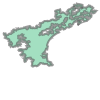

In [ ]:
French_wine_regions['geometry'][6]


In [ ]:
def coord_lister(geom):
    
    if geom.geom_type=='MultiPolygon':
        coords = [list(x.exterior.coords) for x in geom.geoms]
    else:
        coords = list(geom.exterior.coords)        
    return (coords)


In [ ]:

def data_period_pick(path,year_start,year_finish,month_start,month_finish):
    
    delta_year=year_finish-year_start
    delta_month=month_finish-month_start
    data_files=[]
    year_size_data=[]
    
    for i in range(year_start,year_finish+1):
        month_size_data=[]
        for j in range(month_start,month_finish+1):
            year_actual=str(i)
            month_actual=str(j)
            if j <= 9 :
                data_files.append(path+'-'+year_actual+'-'+'0'+month_actual+'.nc')
            else:
                 data_files.append(path+'-'+year_actual+'-'+month_actual+'.nc')
                
            data=netCDF4.Dataset(data_files[-1])
            month_size_data.append(len(data.variables['t2m']))
            
        year_size_data.append(np.sum(month_size_data))
    return data_files,delta_year,delta_month,year_size_data


In [ ]:
def data_year_sep(data,year_size_data):
    
    data_matrix_year=[]
    _iter=0
    
    for i in range(len(year_size_data)):
                                   
        size_year_actual = year_size_data[i]
        _iter_end=_iter+size_year_actual
        data_matrix_year.append(data[int(_iter):int(_iter_end)])                          
        _iter+=year_size_data[i]
            
    return data_matrix_year
                                         

In [ ]:
def coordinates_region(geojson_file,region_choice):
    
        if geojson_file[region_choice].geom_type=='MultiPolygon':

            coordinates = coord_lister(geojson_file[region_choice])
            nb_polygons=len(coordinates)
            
            data_coords=[]
            for j in range(nb_polygons):

                coords = coordinates[j]
                coords=np.round(coords,1)
                min_lat=min(coords[:,1])
                max_lat=max(coords[:,1])
                lat_list_iter=np.arange(min_lat,max_lat,0.1)
            
                for latitude in lat_list_iter:

                    idx_long=np.where(coords[:,1]==np.round(latitude,1))[0]
                    long_values_at_iter_lat=coords[:,0][idx_long]
                    long_list_iter=np.arange(min(long_values_at_iter_lat),max(long_values_at_iter_lat),0.1)
                    
                    for longitude in long_list_iter:
                        
                        data_coords.append([latitude,longitude])
                # Long_list_department.append(long_list)
                
            # return np.hstack(Lat_list_department),Long_list_department
            return data_coords

        else:    
            
            data_coords=[]
            coordinates = coord_lister(geojson_file[region_choice])
            coordinates=np.round(coordinates,1)
            min_lat=min(coordinates[:,1])
            max_lat=max(coordinates[:,1])
            lat_list=np.arange(min_lat,max_lat,0.1)
            
            for latitude in lat_list:

                idx_long=np.where(coordinates[:,1]==np.round(latitude,1))[0]
                long_values_at_iter_lat=coordinates[:,0][idx_long]
                long_list_iter=np.arange(min(long_values_at_iter_lat),max(long_values_at_iter_lat),0.1)
                 
                for longitude in long_list_iter:
                        
                        data_coords.append([latitude,longitude])
                        
            return data_coords
        
def data_ready_model(data_coords,path_picked_files,data_feature):

        data_variable=[]

        for file in range(len(path_picked_files)):

            main_data= netCDF4.Dataset(path_picked_files[file])
            data=np.asarray(main_data.variables[data_feature]).T
            # print(data.shape)
            lat_data = np.asarray(main_data['latitude'])
            long_data = np.asarray(main_data['longitude'])
            meta_data_region_variable=[]
            missing_data_coords_nb=0
            for kk in range(len(data_coords)):
                    
                    latitude_iter=data_coords[kk][0]
                    longitude_iter=data_coords[kk][1]
                    ID_lat = np.where(lat_data==latitude_iter)[0]
                    ID_long = np.where(long_data==longitude_iter)[0]
                    if len(ID_lat)==0 or len(ID_long)==0:
                        missing_data_coords_nb+=1
                        continue
                        
                    data_at_coord=data[ID_long][0][ID_lat]
                    
                    if np.isnan(data_at_coord[0].any())==True:
                        for i in range (len(data_at_coord)):
                            if np.isnan(data_at_coord[0][i])==True:
                                if i ==0:
                                    data_at_coord[0][i]==data_at_coord[0][i+1]
                                else:
                                    data_at_coord[0][i]==data_at_coord[0][i-1]   
                    if data_at_coord[0].any()==-32767:
                        for i in range(len(data_at_coord)):
                            if data_at_coord[0][i]==-32767:
                                if i ==0:
                                    data_at_coord[0][i]==data_at_coord[0][i+1]
                                else:
                                    data_at_coord[0][i]==data_at_coord[0][i-1]                    
                    if data_at_coord[0].any()==0:
                        for i in range(len(data_at_coord)):
                            if data_at_coord[0][i]==0:
                                if i ==0:
                                    data_at_coord[0][i]==data_at_coord[0][i+1]
                                else:
                                    data_at_coord[0][i]==data_at_coord[0][i-1]   
                                    
                    meta_data_region_variable.append(data_at_coord[0])
            
            meta_data_region_variable=np.asarray(meta_data_region_variable)
            nb_data_coords=len(data_coords)- missing_data_coords_nb
            meta_data_region_variable=meta_data_region_variable.reshape((nb_data_coords,len(data_at_coord[0])))

            data_variable=np.append(data_variable,np.mean(meta_data_region_variable,axis=0))
            # print(data_variable.shape)
            
        return data_variable

In [ ]:
def scaler(array):
    scaler = MinMaxScaler()
    array=array.reshape(-1,1)
    scaler.fit(array)
    array=scaler.transform(array)
    return array

In [ ]:

def data_gen_region(data_features,geojson_file,region_choice,scaling,year_start,year_finish):
    
    #Picking the period of data we want 
    
    path_picked_files,nb_years,nb_months,year_size_data=data_period_pick('era1/era5-land',year_start,year_finish,1,12)
    data_region_year=[]           
    data_coords=coordinates_region(geojson_file,region_choice)
    
    for variable in range(len(data_features)):
        
        data = data_ready_model(data_coords,path_picked_files,data_features[variable])
        if scaling==True:
            data=scaler(data)
        
        data_variable_region_year= data_year_sep(data,year_size_data)   
        data_region_year.append(data_variable_region_year)
        
    return data_region_year,nb_months,nb_years,year_size_data




In [ ]:
data_features=['u10', 'v10', 't2m', 'evabs', 'evatc', 'evavt', 'lai_hv', 'lai_lv', 'src', 'stl1', 'sp', 'e', 'tp', 'swvl1']

In [ ]:
production=pd.read_csv('Production_viticole_france_2000_2022.csv')
production 

,Unnamed: 0,Alsace,Bordelais,Bourgogne Beaujolais,Champagne,Charentes,Corse,Jura,Languedoc Roussillon,Savoie,Sud est,Sud ouest,Val de Loire,BBJS
0,2000,"1268,81","7227,31","3211,82","2742,79","8211,92",378,"110,12","19958,96","148,43","7370,87","4545,93","3586,81","1514,83"
1,2001,"1265,22","6913,59","3035,74","2338,92","8508,88",340,"92,97","18156,23","135,9","6201,98","4183,71","3272,45","1490,98"
2,2002,"1264,14","5903,98","3007,01","2538,24","8486,97","75,69","89,26","16578,97","132,79","5950,69","3499,03","3376,16","1469,92"
3,2003,"1015,31","5974,61","1983,34","1642,83","7731,28","299,26","72,18","15276,84","116,52","6169,92","3284,55","3019,23","1238,87"
4,2004,"1353,94","7968,91","3194,11","3278,85","10102,93","364,12","123,56","17781,25","151,38","6037,22","4251,09","3752,56","1616,55"
5,2005,"1195,26","6481,59","2792,99","3002,12","9459,55","351,15","96,88","15955,94","139,05","5765,12","3977,23","3338,56","1423,9"
6,2006,"1109,2","6081,5","2752,95","3080,24","9335,26","347,41","85,89","16313,25","131,76","5974,05","3858,65","3183,57","1312,73"
7,2007,"1205,22","5932,02","2625,39","2994,1","6482,06","311,73",102,"14656,93","117,64","5718,29","3063,79","2890,39","1415,8"
8,2008,"1169,27","4898,15","2279,44","3026,11","6977,02","292,13","93,4","12984,83","108,58","5137,99","2814,93","2261,31","1383,23"
9,2009,"1214,82","6069,09","2550,19","2893,92","8656,6","291,93","82,8","12135,64","120,56","5130,18","3735,27","3159,11","1418,96"


In [ ]:
def gen_labels(years_data,production,regions):
    
    #Méthode classification binaire
    binary_labels=[]
    
    for region in regions:
        
        prod_region=production[region]
        for value in range(len(prod_region)):
            
            prod_region[value]=prod_region[value].replace(',','.')
        prod_region=scaler(np.asarray(prod_region).astype(float))
        
        #Valeur de référence pour la définition des classes
        valeur_olympique=np.mean(prod_region)  
        
        for year in years_data:
            
            year_ref=np.where(production['Unnamed: 0']==year)
            
            if prod_region[year_ref]<valeur_olympique:
                binary_labels.append(int(1))
            if prod_region[year_ref]>valeur_olympique:
                binary_labels.append(int(0))
            
    # Méthode multi classification
                             
    return binary_labels           
    

In [ ]:
def gen_labels2(years_data,production,regions,portion):
    
    #Méthode classification binaire
    binary_labels=[]
    
    for region in regions:
        
        prod_region=production[region]
        for value in range(len(prod_region)):
            
            prod_region[value]=prod_region[value].replace(',','.')
            
        prod_region=scaler(np.asarray(prod_region).astype(float))
        prod_ready_region=np.delete(prod_region,np.argmax(prod_region))
        prod_ready_region=np.delete(prod_ready_region,np.argmin(prod_ready_region))
        
        #Valeur de référence pour la définition des classes
        valeur_olympique=np.mean(prod_ready_region)*portion  
        
        for year in years_data:
            
            year_ref=np.where(production['Unnamed: 0']==year)
            
            if prod_region[year_ref]<valeur_olympique:
                binary_labels.append(int(1))
            if prod_region[year_ref]>valeur_olympique:
                binary_labels.append(int(0))
            
    # Méthode multi classification
                             
    return binary_labels  

In [ ]:
#Filtering dataset by region



def region_filter(region_choice,nb_years,data_matrix,labels,day_nbs):
    
    nb_examples=(len(region_choice)*(nb_years))
    new_data_matrix=np.zeros((nb_examples,int(min(year_size_data)/day_nbs),len(data_features)))
    new_labels = []                            

    region_idx_start=0
    region_idx_end=nb_years-1
    
    
    end=nb_years-1
    start=0
    for region in region_choice:
        
        idx_start=(region*nb_years)
        idx_end=(region*nb_years)+nb_years-1
        new_data_matrix[region_idx_start:region_idx_end+1]=data_matrix[idx_start:idx_end+1]
        new_labels.append(labels[idx_start:idx_end+1])
        

        region_idx_start+=nb_years
        region_idx_end+=nb_years   
        print(idx_start,idx_end)
    return new_data_matrix,np.hstack(new_labels)



In [ ]:
def period_means(arr,year_size_data,choice):
    
    if choice=='day':
    
        day_means=[]
        _iter=0
        while _iter < year_size_data :
            day_actual=[]
            for hour in range(24):
                day_actual.append(arr[_iter])
                _iter+=1
            day_means.append(np.mean(day_actual))
                
#     if choice=='month':
#          month_means=[]
#         _iter=0
#         while _iter < month_size_data:
#             month_actual=[]
            
#             for hour in range(24):
                
#                 _iter+=1
#                 month_actual.append(arr[_iter])
#             month_means.append(np.mean(month_actual))
        
        return day_means       
   # return day_means,month_means

In [ ]:

year_start=2000
year_finish=2022


#Picking all the regions related to the regions of agreste productivity data


French_wine_region_choice=[3,4,5,6,8,10]
# ALSACE ET EST,BOURGOGNE BEAUJOLAIS SAVOIE JURA,CHAMPAGNE,LANGUEDOC-ROUSSILLON,Sud Ouest, Val de Loire

French_departments_choice=[54,71]
# Gironde(pour bordeaux), Charentes

years_data=np.arange(year_start,year_finish+1,1)
nb_years=len(years_data)
nb_features=len(data_features)
nb_examples= (len(French_wine_region_choice)+len(French_departments_choice))*nb_years






idx_match=[1,-1,4,8,11,12,2,5]

region_choice_match_production=np.asarray(production.columns)[idx_match]

binary_labels_pdp=gen_labels(years_data,production,region_choice_match_production)  

path_picked_files,_,_,year_size_data=data_period_pick('era1/era5-land',year_start,year_finish,1,12)


#Checking if meta_data is ordered
time_=[]
for file in path_picked_files:
    
    main_data= netCDF4.Dataset(file)
    data=np.asarray(main_data.variables['time'])
    time_.append(data)
    
time_=np.hstack(time_)
if all(b >= a for a, b in zip(time_, time_[1:]))==True:
    print('Data is ordered well')
    
    
data_matrix_conv = np.zeros((nb_examples,nb_features,int(min(year_size_data)/24)))

idx_region_year_data=0                       

for region in French_wine_region_choice:
    print('Region :', French_wine_regions['Bassin'][region])

    
    data_region,_,_,year_size_data=data_gen_region(data_features,French_wine_regions['geometry'],region,False,year_start,year_finish)
    
    for year in range(nb_years):
        
        for variable in range(len(data_features)):
        
            data_matrix_conv[idx_region_year_data][variable]=period_means(data_region[variable][year],min(year_size_data),'day')
            
        idx_region_year_data+=1 
            

for region in French_departments_choice:
    
    print('Region :', French_departments['nom'][region])

    
    data_region,_,_,year_size_data=data_gen_region(data_features,French_departments['geometry'],region,False,year_start,year_finish)
    
    for year in range(nb_years):
        
        for variable in range(len(data_features)):
        
            data_matrix_conv[idx_region_year_data][variable]=period_means(data_region[variable][year],min(year_size_data),'day')
            
        idx_region_year_data+=1 

    
print(data_matrix_conv.shape)


Data is ordered well
Region : ALSACE ET EST
Region : BOURGOGNE BEAUJOLAIS SAVOIE JURA
Region : CHAMPAGNE
Region : LANGUEDOC-ROUSSILLON
Region : SUD-OUEST
Region : VAL DE LOIRE
Region : Gironde
Region : Charente
(184, 14, 365)


In [ ]:
from sklearn.preprocessing import StandardScaler

### Saving and retrieving processed data

In [ ]:
#Saving data matrix for later use

arr_reshaped = data_matrix_conv.reshape(data_matrix_conv.shape[0], -1)
# saving reshaped array to file.
np.savetxt("Conv_matrix_8reg_22y_unscaled.txt", arr_reshaped)
  


In [ ]:
# retrieving data from file.
data_matrix_conv2D = np.loadtxt("Conv_matrix_8reg_22y_scaled.txt")
  
# This loadedArr is a 2D array, therefore
# we need to convert it to the original
# array shape.reshaping to get original
# matrice with original shape.
data_matrix_conv= data_matrix_conv2D.reshape(
    data_matrix_conv2D.shape[0], data_matrix_conv2D.shape[1] // data_matrix_conv.shape[2], data_matrix_conv.shape[2])

In [ ]:
print(data_matrix_conv.shape)

(184, 365, 14)


### Calculating of the weights of the samples

In [ ]:
#Calculating initial weights for each class


zero_class_nb=0
one_class_nb=0
for i in range(len(binary_labels_pdp)):
    if binary_labels_pdp[i]==0:
        
        zero_class_nb+=1
    else:
        one_class_nb+=1

In [ ]:
weight_for_0 = (1 / zero_class_nb) * (len(binary_labels_pdp) / 2.0)
weight_for_1 = (1 / one_class_nb) * (len(binary_labels_pdp) / 2.0)
print(weight_for_0,weight_for_1)
class_weight = {0: weight_for_0, 1: weight_for_1}

1.0 1.0


## Modèles et scores de classification

### Réseau de neurones Conv1D

In [ ]:
# data_matrix_conv_saved_unscaled=data_matrix_conv_saved_unscaled.reshape((nb_examples,int(min(year_size_data)/24),len(data_features)))

In [ ]:
data_matrix_conv=data_matrix_conv.reshape((nb_examples,int(min(year_size_data)/24),len(data_features)))

In [ ]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Conv1D, Conv2D,Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D, BatchNormalization
from keras.layers.convolutional import MaxPooling1D,AveragePooling1D,MaxPooling2D
import tensorflow.keras
import tensorflow as tf

from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Dense, Activation, Concatenate
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
import h5py
from keras.models import load_model


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
rand_state=np.random.randint(50)

In [ ]:

#Filtering dataset by features and regions

year_start=2000
year_finish=2022

years_data=np.arange(year_start,year_finish+1,1)


idx_match=[1,-1,4,8,11,12,2,5]

#best regions filtered
region_choice=[0,1,4,5]

# region_choice=[0,1,2,3,4,5,6,7]
# ALSACE ET EST,BOURGOGNE BEAUJOLAIS SAVOIE JURA,CHAMPAGNE,LANGUEDOC-ROUSSILLON,Sud Ouest, Val de Loire,Gironde(pour bordeaux), Charentes


region_choice_match_production=np.asarray(production.columns)[idx_match]
nb_years=23
binary_labels_pdp=gen_labels(years_data,production,region_choice_match_production)


data_matrix,labels=region_filter(region_choice,nb_years,data_matrix_conv,binary_labels_pdp,24)



# ['u10','v10','t2m', 'evabs', 'evatc', 'evavt', 'lai_hv', 'lai_lv', 'src', 'stl1', 'sp', 'e', 'tp', 'swvl1']
# feature_choice=[0,1,2,3,4,5,6,7,8,9,10,11,12,13]
feature_choice=[0,1,2,3,4,5,8,9,10,11,12,13]

# feature_choice=[0,1,2,3,4,5,6,7,8,9,10,11,12,13]


# feature_choice=[0,2,10,11,12,13]

data_matrix=data_matrix.T[feature_choice]
data_matrix=data_matrix.T
data_matrix.shape



0 22
23 45
92 114
115 137


(92, 365, 12)

In [ ]:

drop_out_rate=0.1
outlayer_neurons=128

optimizer = keras.optimizers.Adam(lr=0.005)
optimizers_list=['RMSprop']
# optimizers_list=['Adam']
rand_state=np.random.randint(50)                  


for opti in optimizers_list:
    f1=[]
    # rand_state=np.random.randint(50)
    for i in range(4):

        
                #Construction et définition du réseau de neurones 
            
        model = Sequential([

              layers.Conv1D(256, 14, padding='same', activation='relu', input_shape=(int(min(year_size_data)/24),len(feature_choice))),
              layers.MaxPooling1D(pool_size=8),
              layers.Dropout(drop_out_rate),
              layers.Conv1D(128, 4, padding='same', activation='relu'),
              layers.Dropout(drop_out_rate),
              layers.Conv1D(64, 2, padding='same', activation='relu'),
              layers.Dropout(drop_out_rate),
              layers.Flatten(),
              layers.Dense(outlayer_neurons, activation='relu'),
              layers.Dense(2,activation='softmax')
            ])
            

        # Model 1 -  Variant
#         model = Sequential([

#           layers.Conv1D(256,12, padding='same', activation='relu', input_shape=(int(min(year_size_data)/24),nb_features)),
#           # layers.AveragePooling1D(pool_size=8),
#           layers.MaxPooling1D(pool_size=8),
#           layers.Dropout(drop_out_rate),
#           layers.Conv1D(128, 4, padding='same', activation='relu'),
#           layers.MaxPooling1D(pool_size=4),
#           layers.Dropout(drop_out_rate),
#           # layers.Conv1D(64, 2, padding='same', activation='relu'),
#           # layers.MaxPooling1D(pool_size=2),
#           # layers.Dropout(drop_out_rate),
#           layers.Flatten(),
#           # layers.Dense(outlayer_neurons*2, activation='relu'),
#           layers.Dense(outlayer_neurons, activation='relu'),
#           layers.Dropout(drop_out_rate),
#           layers.Dense(2,activation='softmax')
#             ])            
             

          # Second Model : 
#         model = Sequential([

#           layers.Conv1D(16, 14, padding='same', activation='relu', input_shape=(int(min(year_size_data)/24),nb_features)),
#           layers.MaxPooling1D(pool_size=2),
#           layers.Dropout(drop_out_rate),

#           layers.Conv1D(32, 10, padding='same', activation='relu', input_shape=(int(min(year_size_data)/24),nb_features)),
#           layers.MaxPooling1D(pool_size=2),
#           layers.Dropout(drop_out_rate),
#           layers.Conv1D(64, 5, padding='same', activation='relu'),
#           layers.MaxPooling1D(pool_size=2),
#           layers.Dropout(drop_out_rate),
#           layers.Conv1D(128, 3, padding='same', activation='relu'),
#           layers.MaxPooling1D(pool_size=2),
#           layers.Dropout(drop_out_rate),
#           layers.Flatten(),
#           layers.Dense(outlayer_neurons*2, activation='relu'),
#           layers.Dense(outlayer_neurons, activation='relu'),
#           layers.Dropout(drop_out_rate),
#           layers.Dense(2,activation='softmax')
#             ])


        #Compilation du modèle


        model.compile(optimizer=opti,loss='binary_crossentropy',metrics='binary_accuracy' )


        #Séparation des données test et entraînement
        x_train, x_test, y_train, y_test = train_test_split(data_matrix,to_categorical(labels), test_size=0.01,random_state=rand_state)

        # callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True,start_from_epoch=15)
        # callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,restore_best_weights=True,start_from_epoch=10)

       
        mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0,save_best_only=True,start_from_epoch=20)

        
        
        
#         scalers = {}
#         # print(x_train.shape)
#         # print(x_train[0].shape)
#         print(x_train[0][0])
#         for i in range(x_train.shape[2]):
#             scalers[i] = MinMaxScaler()
#             x_train[:, :, i] = scalers[i].fit_transform(x_train[:, :, i]) 

#         for i in range(x_test.shape[2]):
#             x_test[:, :, i] = scalers[i].transform(x_test[:, :, i]) 
#         # print(x_train.shape)
#         # print(x_train[0].shape)
#         print(x_train[0][0])

        history=model.fit(x_train, y_train,
                            epochs=50,
                            batch_size=4,verbose=1,class_weight=class_weight,validation_split=0.25,callbacks=[mc])
        
        
        

#         history=model.fit(x_train, y_train,
#                             epochs=40,
#                             batch_size=4,verbose=1,class_weight=class_weight,callbacks=[mc])
        
        saved_model = load_model('best_model.h5')
        y_true=[]
        pred_labels=[]
        # prob_class=model.predict(x_test)
        prob_class=saved_model.predict(x_test)

        
        for prob in prob_class:

            pred_labels.append(np.argmax(prob))

        for example in range(len(y_test)):
            y_true.append(np.argmax(y_test[example]))

        f1.append(f1_score(y_true,pred_labels))
    print('Optimiseur :', opti)
    print('Score de classification')
    print(np.round(np.mean(f1)*100,2),'+-',np.round(np.std(f1)*100,2),'%')
    print(f1)

Epoch 1/50
17/17 [==============================] - 2s 78ms/step - loss: 0.8235 - binary_accuracy: 0.4853 - val_loss: 0.6913 - val_binary_accuracy: 0.5217
Epoch 2/50
17/17 [==============================] - 1s 68ms/step - loss: 0.7388 - binary_accuracy: 0.4853 - val_loss: 0.7024 - val_binary_accuracy: 0.4783
Epoch 3/50
17/17 [==============================] - 1s 67ms/step - loss: 0.7131 - binary_accuracy: 0.5294 - val_loss: 0.6936 - val_binary_accuracy: 0.4783
Epoch 4/50
17/17 [==============================] - 1s 58ms/step - loss: 0.7010 - binary_accuracy: 0.4706 - val_loss: 0.6945 - val_binary_accuracy: 0.4783
Epoch 5/50
17/17 [==============================] - 1s 65ms/step - loss: 0.6989 - binary_accuracy: 0.4853 - val_loss: 0.6960 - val_binary_accuracy: 0.4783
Epoch 6/50
17/17 [==============================] - 1s 67ms/step - loss: 0.7161 - binary_accuracy: 0.4853 - val_loss: 0.6930 - val_binary_accuracy: 0.4783
Epoch 7/50
17/17 [==============================] - 1s 64ms/step - los

In [ ]:
# Main : 0.7838

# no 7 : 0.8750+
# no 6 : 0.8750-
# no 5: 0.75-
# no 4: 0.75-
# no 3 : 0.8125
# no 2 : 0.7812+
# no 1 : 0.718--
# no 0 : 0.718--
    

In [ ]:
# First Model 

# Optimiseur : Adam
# Score de classification
# 77.72 +- 5.29 %
# [0.7027027027027027, 0.8085106382978724, 0.8205128205128205]

# First Model - Variant

# Optimiseur : Adam
# Score de classification
# 66.61 +- 2.79 %
# [0.7000000000000001, 0.631578947368421, 0.6666666666666666]


# Second Model

# Optimiseur : Adam
# Score de classification
# 48.61 +- 8.56 %
# [0.375, 0.5833333333333334, 0.5]

# Optimiseur : RMSprop
# Score de classification
# 45.83 +- 32.81 %
# [0.0, 0.625, 0.75]

# Third_Model : (furthers tests needed)

# Optimiseur : RMSprop
# # Score de classification
# # 52.31 +- 9.92 %
# # [0.4, 0.5263157894736842, 0.6428571428571429]

# Optimiseur : Adam
# Score de classification
# 67.7 +- 9.44 %

# Optimiseur : RMSprop
# Score de classification
# 43.97 +- 32.75 %
# [0.7857142857142858, 0.5333333333333333, 0.0]

SyntaxError: invalid syntax (537220151.py, line 4)

In [ ]:
# Extract last year from dataset to predict on it


data_filter_year = np.delete(data_matrix_conv, np.arange(0, len(binary_labels_pdp), 23),axis=0)
test_year_data=data_matrix_conv[np.arange(0,len(binary_labels_pdp),23)]
# data_test =  data_matrix_conv[test_year_data] 
print(test_year_data.shape)

nb_regions=8
portions=[1,0.8,0.7,0.6,0.5]
prob_csv=[]
                  
drop_out_rate=0.1
outlayer_neurons=128
optimizers_list=['RMSprop']
rand_state=np.random.randint(50)                  
for portion in portions:
    
        
                #Construction et définition du réseau de neurones 
        opt = tf.keras.optimizers.experimental.RMSprop(learning_rate=0.001)
        years_data=np.arange(2000,2022)
        binary_labels_pdp=gen_labels2(years_data,production,region_choice_match_production,portion)    
            
        # First Model:    
        model = Sequential([

              layers.Conv1D(256, 14, padding='same', activation='relu', input_shape=(int(min(year_size_data)/24),nb_features)),
              layers.MaxPooling1D(pool_size=8),
              layers.Dropout(drop_out_rate),
              layers.Conv1D(128, 4, padding='same', activation='relu'),
              layers.Dropout(drop_out_rate),
              layers.Conv1D(64, 2, padding='same', activation='relu'),
              layers.Dropout(drop_out_rate),
              layers.Flatten(),
              layers.Dense(outlayer_neurons, activation='relu'),
              layers.Dense(2,activation='softmax')
            ])

        
#         model = Sequential([

#               layers.Conv1D(14, 14, padding='same', activation='relu', input_shape=(int(min(year_size_data)/24),nb_features)),
#               layers.MaxPooling1D(pool_size=1),
#               layers.Dropout(drop_out_rate),
#               layers.Conv1D(6, 4, padding='same', activation='relu'),
#               layers.Dropout(drop_out_rate),
#               layers.Conv1D(4, 2, padding='same', activation='relu'),
#               layers.Dropout(drop_out_rate),
#               layers.Flatten(),
#               layers.Dense(outlayer_neurons, activation='relu'),
#               layers.Dense(2,activation='softmax')
#             ])
        
        
        #Compilation du modèle

        model.compile(optimizer=opt,loss='binary_crossentropy',metrics='binary_accuracy' )


        #Séparation des données test et entraînement
        x_train, x_test, y_train, y_test = train_test_split(data_filter_year,to_categorical(binary_labels_pdp), test_size=0.01,random_state=rand_state)

       
        mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0,save_best_only=True,start_from_epoch=10)

        history=model.fit(x_train, y_train,
                            epochs=80,
                            batch_size=4,verbose=1,class_weight=class_weight,validation_split=0.2,callbacks=[mc])
    
        saved_model = load_model('best_model.h5')
         
        prob_csv.append(np.asarray(saved_model.predict(test_year_data)))
        print('Portion probabilities :',np.asarray(saved_model.predict(test_year_data))) 

(8, 365, 14)
Epoch 1/80
35/35 [==============================] - 2s 38ms/step - loss: 0.7017 - binary_accuracy: 0.5036 - val_loss: 0.6934 - val_binary_accuracy: 0.4286
Epoch 2/80
35/35 [==============================] - 1s 29ms/step - loss: 0.6925 - binary_accuracy: 0.4604 - val_loss: 0.6934 - val_binary_accuracy: 0.4571
Epoch 3/80
35/35 [==============================] - 1s 33ms/step - loss: 0.6934 - binary_accuracy: 0.5252 - val_loss: 0.6934 - val_binary_accuracy: 0.4571
Epoch 4/80
35/35 [==============================] - 1s 32ms/step - loss: 0.6995 - binary_accuracy: 0.4604 - val_loss: 0.6914 - val_binary_accuracy: 0.5429
Epoch 5/80
35/35 [==============================] - 1s 29ms/step - loss: 0.6970 - binary_accuracy: 0.4820 - val_loss: 0.6942 - val_binary_accuracy: 0.4857
Epoch 6/80
35/35 [==============================] - 1s 29ms/step - loss: 0.6966 - binary_accuracy: 0.5755 - val_loss: 0.6921 - val_binary_accuracy: 0.5143
Epoch 7/80
35/35 [==============================] - 1s 30

KeyboardInterrupt: 

In [ ]:
# data_features=['u10', 'v10', 't2m', 'evabs', 'evatc', 'evavt', 'lai_hv', 'lai_lv', 'src', 'stl1', 'sp', 'e', 'tp', 'swvl1']

In [ ]:





# # data_occurences_in_new_period

# drop_out_rate=0.1
# outlayer_neurons=128

# # callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4,restore_best_weights=True)


# optimizers_list=['RMSprop']


# f1=[]
# # rand_state=np.random.randint(50)
# for i in range(5):

#     rand_state=np.random.randint(50)
#             #Construction et définition du réseau de neurones 

#     model = Sequential([

#       layers.Conv1D(256, 6, padding='same', activation='relu', input_shape=(int(min(year_size_data)/24),len(feature_choice))),
#       # layers.AveragePooling1D(pool_size=8),
#       layers.MaxPooling1D(pool_size=8),
#       layers.Dropout(drop_out_rate),
#       layers.Conv1D(128, 4, padding='same', activation='relu'),
#       # layers.MaxPooling1D(pool_size=6),
#       # layers.AveragePooling1D(pool_size=6),
#       layers.Dropout(drop_out_rate),
#       layers.Conv1D(64, 2, padding='same', activation='relu'),

#       # layers.AveragePooling1D(),
#       layers.Dropout(drop_out_rate),
#       layers.Flatten(),
#       layers.Dense(outlayer_neurons, activation='relu'),
#       layers.Dense(2,activation='softmax')
#         ])



#     #Compilation du modèle


#     model.compile(optimizer='RMSprop',loss='binary_crossentropy',metrics='accuracy' )


#     #Séparation des données test et entraînement
#     x_train, x_test, y_train, y_test = train_test_split(data_matrix_conv_fvar,to_categorical(binary_labels_pdp), test_size=0.1,random_state=rand_state)

#     # callback = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=10,restore_best_weights=True,start_from_epoch=15)


#     # history=model.fit(x_train, y_train,
#     #                     epochs=120,
#     #                     batch_size=16,verbose=1,class_weight=class_weight,validation_split=0.3)

#     history=model.fit(x_train, y_train,
#                         epochs=30,
#                         batch_size=2,verbose=1,class_weight=class_weight,validation_split=0.3)
 
#     y_true=[]
#     pred_labels=[]
#     prob_class=model.predict(x_test)


#     for prob in prob_class:

#         pred_labels.append(np.argmax(prob))

#     for example in range(len(y_test)):
#         y_true.append(np.argmax(y_test[example]))

#     f1.append(f1_score(y_true,pred_labels))
# print('Optimiseur :', opti)
# print('Score de classification')
print(np.round(np.mean(f1)*100,2),'+-',np.round(np.std(f1)*100,2),'%')

Epoch 1/30
58/58 [==============================] - 19s 189ms/step - loss: 0.7748 - accuracy: 0.5217 - val_loss: 0.6996 - val_accuracy: 0.6000
Epoch 2/30
58/58 [==============================] - 6s 98ms/step - loss: 0.7241 - accuracy: 0.4609 - val_loss: 0.6941 - val_accuracy: 0.4000
Epoch 3/30
58/58 [==============================] - 9s 149ms/step - loss: 0.7049 - accuracy: 0.5217 - val_loss: 0.6963 - val_accuracy: 0.4000
Epoch 4/30
58/58 [==============================] - 9s 137ms/step - loss: 0.6996 - accuracy: 0.5217 - val_loss: 0.7296 - val_accuracy: 0.4000
Epoch 5/30
58/58 [==============================] - 7s 118ms/step - loss: 0.6980 - accuracy: 0.5043 - val_loss: 0.6962 - val_accuracy: 0.4000
Epoch 6/30
58/58 [==============================] - 7s 108ms/step - loss: 0.6985 - accuracy: 0.5739 - val_loss: 0.7292 - val_accuracy: 0.4000
Epoch 7/30
58/58 [==============================] - ETA: 0s - loss: 0.7123 - accuracy: 0.5391

### PYTS time series classification and time window importance

In [ ]:
# import matplotlib.pyplot as plt
# feature_test=x_train.reshape((nb_years,nb_examples*0.9,min(year_size_data)))[-1]


# clf = TimeSeriesForest(random_state=43)
# clf.fit(feature_test, y_train)

# start_idxmax, end_idxmax = clf.indices_[
#     np.argmax(clf.feature_importances_) // 3]

# plt.figure(figsize=(12, 5))
# plt.plot(feature_test[0], label='First sample in class 1')
# plt.plot(np.arange(start_idxmax, end_idxmax),
#          feature_test[0,start_idxmax:end_idxmax],
#          color='C0', lw=4)

# plt.plot(feature_test[-1], label='First sample in class 0')
# plt.plot(np.arange(start_idxmax, end_idxmax),
#          feature_test[-1, start_idxmax:end_idxmax],
#          color='C1', lw=4)

# plt.legend(loc='best', fontsize=14)
# plt.title('The most important window according to the feature importance '
#           'scores', fontsize=16)
# plt.tight_layout()
# plt.show()


TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
# import pyts
# from pyts.classification import BOSSVS
# from pyts.multivariate.classification import MultivariateClassifier
# from pyts.classification import TimeSeriesForest
# features_scores=[]
# for i in range(len(data_features)):
    
#     x_train, x_test, y_train, y_test = train_test_split(data_matrix_conv,binary_labels_pdp, test_size=0.3, random_state=np.random.randint(100))
#     feature_train=x_train.reshape((14,len(y_train),365))[i]
#     feature_test=x_test.reshape((14,len(y_test),365))[i]
#     f1=[]
#     for exp in range(1):
        


#         clf = TimeSeriesForest(random_state=np.random.randint(100))
#         clf.fit(feature_train, y_train)
        
#         prediction= clf.predict(feature_test)

#         #Evaluation de la précision de classification du modèle
#         f1.append(f1_score(y_test,prediction))
#     features_scores.append([np.mean(f1),data_features[i]])
# print(features_scores)

[[0.3636363636363636, 'u10'], [0.4615384615384615, 'v10'], [0.20689655172413793, 't2m'], [0.4827586206896552, 'evabs'], [0.3846153846153846, 'evatc'], [0.20689655172413796, 'evavt'], [0.3703703703703704, 'lai_hv'], [0.2608695652173913, 'lai_lv'], [0.23076923076923075, 'src'], [0.24, 'stl1'], [0.29629629629629634, 'sp'], [0.4166666666666667, 'e'], [0.4666666666666667, 'tp'], [0.17391304347826086, 'swvl1']]


### BOSSVS Multivariate time series classification

In [ ]:
# import pyts
# from pyts.classification import BOSSVS
# from pyts.multivariate.classification import MultivariateClassifier
# from pyts.classification import TimeSeriesForest

# f1=[]
# for i in range(1):
    
#     x_train, x_test, y_train, y_test = train_test_split(data_matrix_conv,binary_labels_pdp, test_size=0.5, random_state=np.random.randint(100))
#     clf = MultivariateClassifier(BOSSVS(n_bins=2,anova=False,word_size=2,drop_sum=False))
    
#     clf.fit(x_train, y_train)
#     MultivariateClassifier(...)
#     clf.predict(x_test)

#     clf.fit(x_train, y_train)

#     #Prédiction sur les données de test avec le modèle entraîné 

#     prediction= clf.predict(x_test)

#     #Evaluation de la précision de classification du modèle
#     f1.append(f1_score(y_test,prediction))
# print('Score moyen de prédiction de classes pour ', nb_examples,' examples de résultats de production')

# print(np.mean(f1),'+-',np.std(f1))


Score moyen de prédiction de classes pour  184  examples de résultats de production
0.4864864864864865 +- 0.0
